# Load image

In [109]:
from torchvision.transforms import v2
from torchvision.io import read_image
import matplotlib.pyplot as plt
import cv2 
import numpy as np

%matplotlib inline


image_path = "./image/three_ships_horizon.JPG"
image = cv2.imread(image_path)
H, W, D = image.shape
print(H, W, D)


1200 1600 3


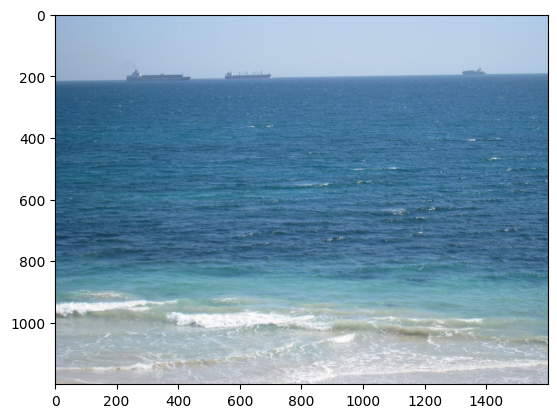

In [110]:
def cv2_imshow(cv2image):
    plt.imshow(cv2.cvtColor(cv2image, cv2.COLOR_BGR2RGB))
    plt.show()

cv2_imshow(image)


# Horizon line detection

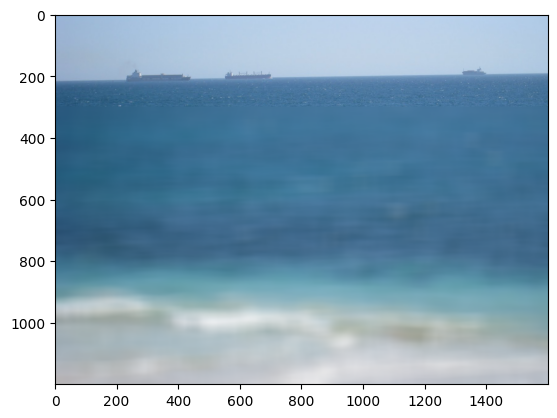

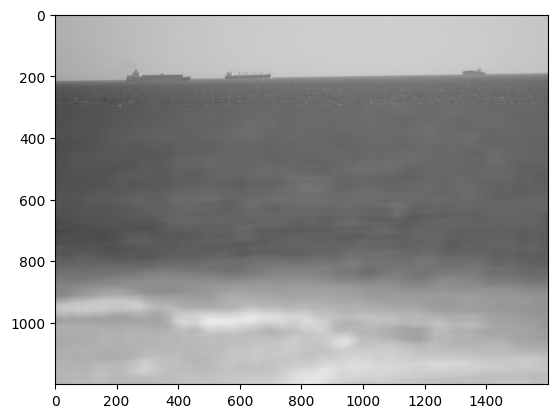

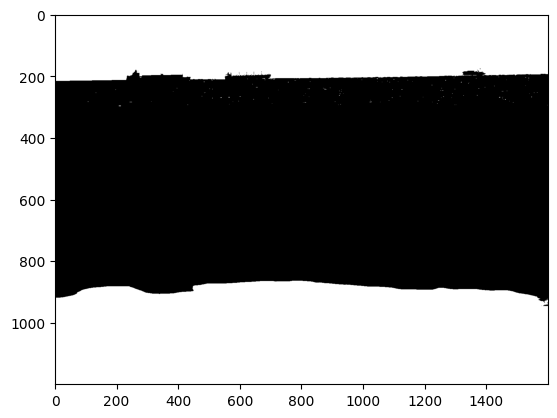

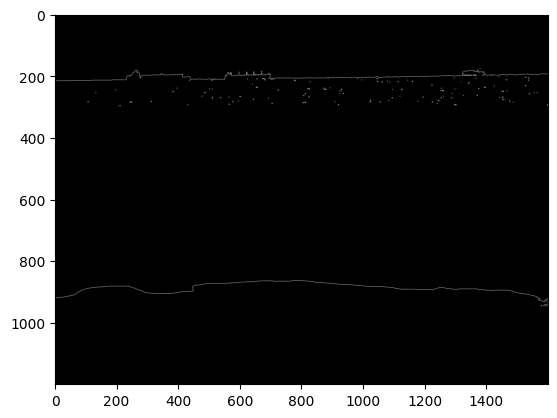

In [111]:
blur_img = image.copy()
blur_img[H//4:H, :] = cv2.blur(blur_img[H//4:H,:],(50,50))
gray = cv2.cvtColor(blur_img, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
cv2_imshow(blur_img)
cv2_imshow(gray)
cv2_imshow(thresh)
cv2_imshow(edges)

## HoughLines Polar

[[[222.         1.553343]]]


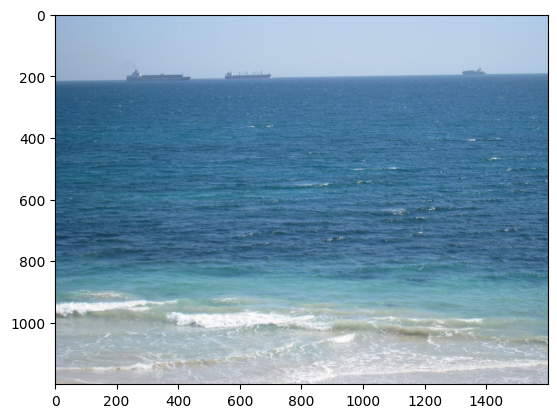

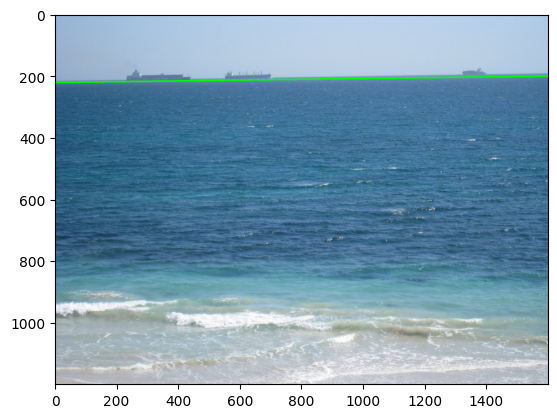

In [112]:

lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

print(lines)

line_draw_img = image.copy()
line = lines[0]
rho, theta = line[0][0], line[0][1]

cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
x0 = cos_theta * rho
y0 = sin_theta * rho
x1 = int(x0 + W * (-sin_theta))
y1 = int(y0 + H * (cos_theta))
x2 = int(x0 - W * (-sin_theta))
y2 = int(y0 - H * (cos_theta))
    
cv2.line(line_draw_img, (x1, y1), (x2,y2), (0, 255, 0), 3)    

cv2_imshow(image)
cv2_imshow(line_draw_img)

In [113]:
x0, y0, x1, y1, x2, y2, cos_theta, sin_theta, theta

(3.8744292, 221.96619, -1595, 242, 1603, 201, 0.017452383, 0.9998477, 1.553343)

## HoughLines Probalistic

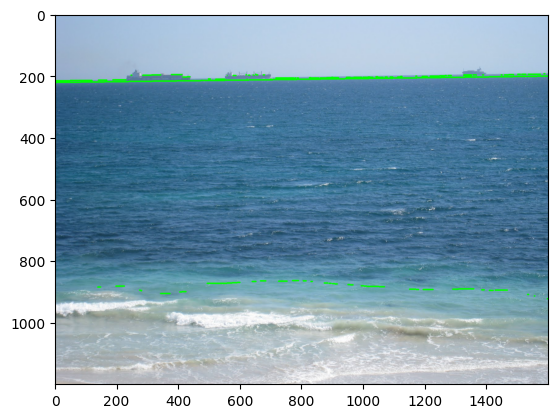

In [30]:

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, )
for line in lines: 
    x1, y1, x2, y2 = line[0]
    new_img = cv2.line(image, (x1, y1), (x2,y2), (0, 255, 0), 3)
cv2_imshow(new_img)

# Leveling horizon line

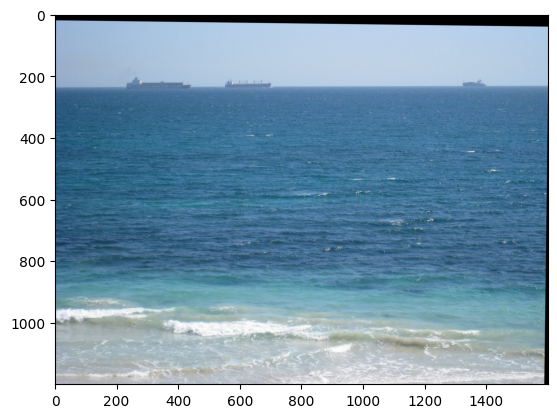

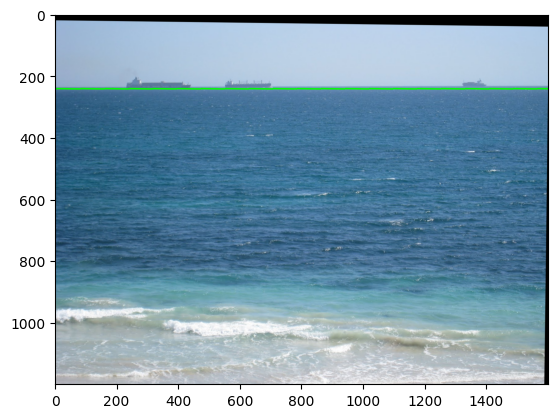

In [114]:
level_angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
rotate_matrix = cv2.getRotationMatrix2D((x1,y1), angle=level_angle, scale=1) 
rotated_image = cv2.warpAffine( 
    src=image, M=rotate_matrix, dsize=(image.shape[1], image.shape[0])) 
rotated_image_with_line = cv2.warpAffine( 
    src=line_draw_img, M=rotate_matrix, dsize=(image.shape[1], image.shape[0])) 
cv2_imshow(rotated_image)
cv2_imshow(rotated_image_with_line)

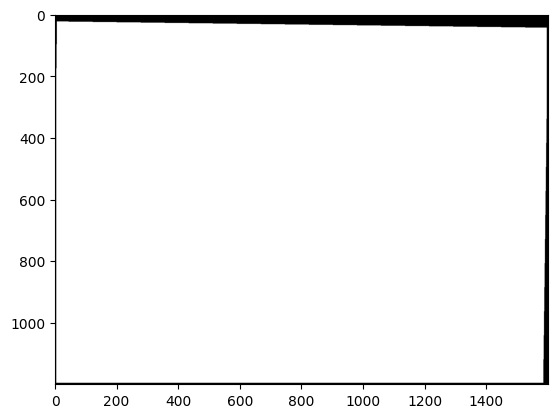

In [115]:
grayscale = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
ret, thresholded = cv2.threshold(grayscale, 0, 255, 0)

bbox = cv2.boundingRect(thresholded)
x, y, w, h = bbox
contours, hier= cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


for k, _ in enumerate(contours):
    im = cv2.cvtColor(cv2.drawContours(thresholded, contours, k, (0, 0, 255), 6),cv2.COLOR_BGR2RGB)

plt.imshow(im)


In [116]:
x, y = contours[0].T[0][0], contours[0].T[1][0]
x, y

(array([   2,    2,    1,    1,    0,    0, 1587, 1587, 1588, 1588, 1589,
        1589, 1590, 1590, 1591, 1591, 1592, 1592, 1593, 1593, 1594, 1594,
        1595, 1595, 1596, 1596, 1597, 1597, 1598, 1598, 1599, 1599, 1526,
        1525, 1448, 1447, 1370, 1369, 1292, 1291, 1214, 1213, 1136, 1135,
        1058, 1057,  980,  979,  902,  901,  824,  823,  746,  745,  668,
         667,  590,  589,  512,  511,  434,  433,  356,  355,  278,  277,
         200,  199,  122,  121,   44,   43], dtype=int32),
 array([  20,   97,   98,  175,  176, 1199, 1199, 1198, 1197, 1120, 1119,
        1042, 1041,  964,  963,  886,  885,  808,  807,  730,  729,  652,
         651,  574,  573,  496,  495,  418,  417,  340,  339,   40,   40,
          39,   39,   38,   38,   37,   37,   36,   36,   35,   35,   34,
          34,   33,   33,   32,   32,   31,   31,   30,   30,   29,   29,
          28,   28,   27,   27,   26,   26,   25,   25,   24,   24,   23,
          23,   22,   22,   21,   21,   20], dtype=in

In [117]:
def find_contours_boundary(x,y): 
    x_max_arg = len(x)-np.argmax(x[::-1])-1
    return y[x_max_arg]

In [118]:
y_at_x_max = find_contours_boundary(x, y)
x_at_y_max = find_contours_boundary(y, x)
cropped_image = rotated_image[y_at_x_max:y_at_x_max+h, :x_at_y_max]
cropped_image_with_line = rotated_image_with_line[y_at_x_max:y_at_x_max+h, :x_at_y_max]

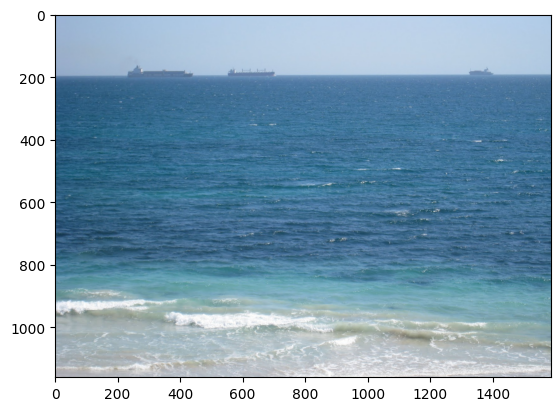

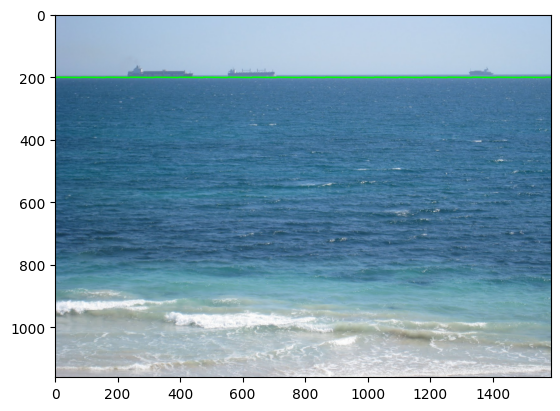

In [119]:
cv2_imshow(cropped_image)
cv2_imshow(cropped_image_with_line)

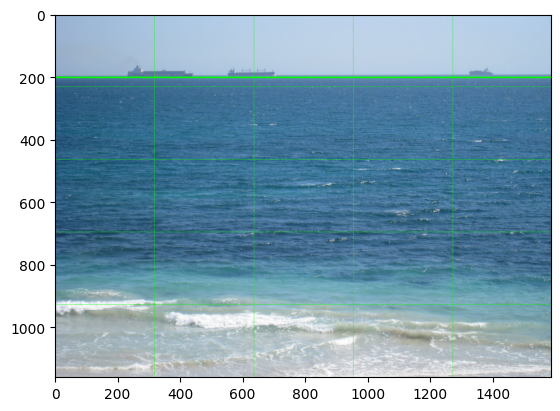

In [120]:
import cv2 as cv  
import numpy as np

# view grid to check level
def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

draw_grid(cropped_image_with_line, (5,5))
cv2_imshow(cropped_image_with_line)

# Ship detection

In [121]:
# redetect line
gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_TOZERO)
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
print(lines)

# detect objects from this line
line = lines[0]
rho, theta = line[0][0], line[0][1]

cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
x0 = cos_theta * rho
y0 = sin_theta * rho
x1 = int(x0 + cropped_image.shape[1] * (-sin_theta))
y1 = int(y0 + cropped_image.shape[0] * (cos_theta))
x2 = int(x0 - cropped_image.shape[1] * (-sin_theta))
y2 = int(y0 - cropped_image.shape[0] * (cos_theta))


[[[1.9400000e+02 1.5707964e+00]]

 [[1.1340000e+03 1.5707964e+00]]

 [[1.1260000e+03 1.5882496e+00]]

 [[1.1280000e+03 1.5707964e+00]]

 [[7.2000000e+02 1.5358897e+00]]

 [[7.0900000e+02 1.5533431e+00]]

 [[1.1370000e+03 1.5707964e+00]]

 [[1.1240000e+03 1.5882496e+00]]

 [[7.4300000e+02 1.5009831e+00]]

 [[6.2400000e+02 1.5533431e+00]]

 [[1.1150000e+03 1.5882496e+00]]

 [[5.5800000e+02 1.5533431e+00]]

 [[1.1580000e+03 1.5533431e+00]]

 [[9.2600000e+02 1.7104226e+00]]

 [[1.0530000e+03 1.6231562e+00]]

 [[1.1780000e+03 1.5358897e+00]]

 [[1.0950000e+03 1.6057029e+00]]

 [[7.2700000e+02 1.5358897e+00]]

 [[9.0800000e+02 1.7278759e+00]]

 [[7.5400000e+02 1.4835298e+00]]

 [[6.4900000e+02 1.5009831e+00]]

 [[5.5600000e+02 1.5533431e+00]]

 [[1.1200000e+03 1.5882496e+00]]

 [[7.1700000e+02 1.5358897e+00]]

 [[1.0510000e+03 1.6231562e+00]]

 [[9.0200000e+02 1.7278759e+00]]

 [[7.5300000e+02 1.5358897e+00]]

 [[7.5800000e+02 1.5358897e+00]]

 [[1.1730000e+03 1.5358897e+00]]

 [[1.1290000e+

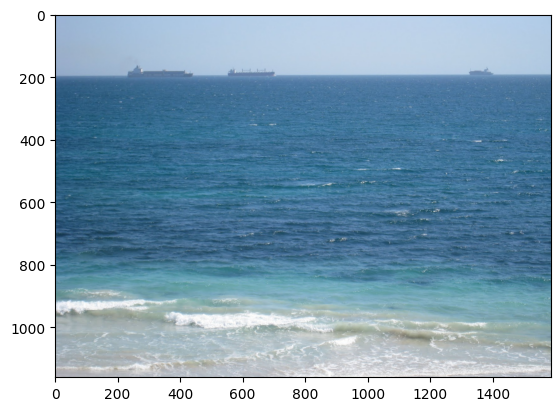

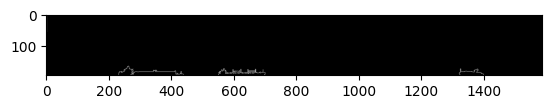

In [144]:
# blur_img = cropped_image.copy()
cropped_image_upper= cropped_image[0: y1, :]
gray = cv2.cvtColor(cropped_image_upper, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_TOZERO)
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
kernel_size = (5,5)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2_imshow(cropped_image)
cv2_imshow(edges)

1321 173 80 20
551 172 151 21
232 164 209 29
1530 0 57 2
0 0 3 193


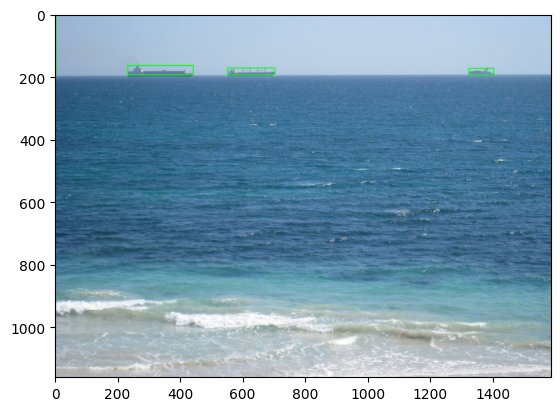

In [145]:
ship_detect = cropped_image.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # if y < 200:
    print(x, y, w, h)
    cv2.rectangle(ship_detect, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(ship_detect)

In [146]:
for contour in contours:
    print(contour.squeeze())

[[1325  173]
 [1325  183]
 [1323  185]
 [1322  185]
 [1322  186]
 [1321  187]
 [1322  188]
 [1322  189]
 [1323  190]
 [1323  192]
 [1324  192]
 [1324  190]
 [1323  189]
 [1323  185]
 [1324  184]
 [1325  184]
 [1327  182]
 [1338  182]
 [1339  181]
 [1360  181]
 [1361  182]
 [1364  182]
 [1365  183]
 [1370  183]
 [1370  182]
 [1371  181]
 [1371  178]
 [1373  176]
 [1377  176]
 [1378  177]
 [1378  183]
 [1377  184]
 [1376  184]
 [1390  184]
 [1392  186]
 [1392  188]
 [1396  188]
 [1397  189]
 [1398  189]
 [1399  190]
 [1399  192]
 [1400  192]
 [1400  190]
 [1399  189]
 [1397  189]
 [1396  188]
 [1393  188]
 [1392  187]
 [1392  185]
 [1391  185]
 [1390  184]
 [1381  184]
 [1380  183]
 [1380  179]
 [1381  178]
 [1384  178]
 [1382  176]
 [1382  175]
 [1381  174]
 [1381  173]
 [1379  173]
 [1379  174]
 [1377  176]
 [1372  176]
 [1370  178]
 [1369  178]
 [1369  181]
 [1368  182]
 [1362  182]
 [1361  181]
 [1346  181]
 [1345  180]
 [1342  180]
 [1341  181]
 [1338  181]
 [1337  182]
 [1328  182]

In [72]:
upper_contours = []
for contour_el in contours:
    countour = contour_el.squeeze()
    upper_contours.append(np.where(contour[1]<193))
upper_contours

[(array([0, 0]), array([0, 1])),
 (array([0, 0]), array([0, 1])),
 (array([0, 0]), array([0, 1])),
 (array([0, 0]), array([0, 1])),
 (array([0, 0]), array([0, 1])),
 (array([0, 0]), array([0, 1])),
 (array([0, 0]), array([0, 1])),
 (array([0, 0]), array([0, 1])),
 (array([0, 0]), array([0, 1])),
 (array([0, 0]), array([0, 1])),
 (array([0, 0]), array([0, 1]))]

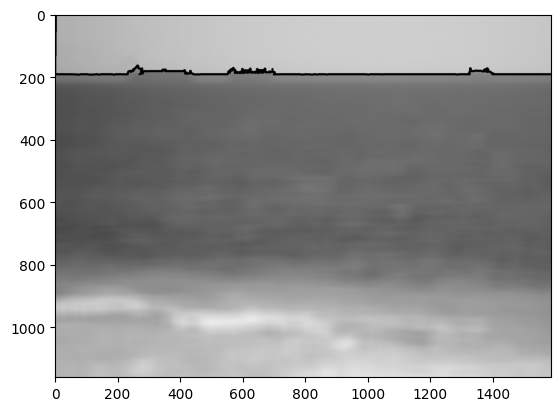

In [70]:

for k, _ in enumerate(contours):
    im = cv2.cvtColor(cv2.drawContours(thresh, contours, k, (0, 0, 255), 6),cv2.COLOR_BGR2RGB)

plt.imshow(im)

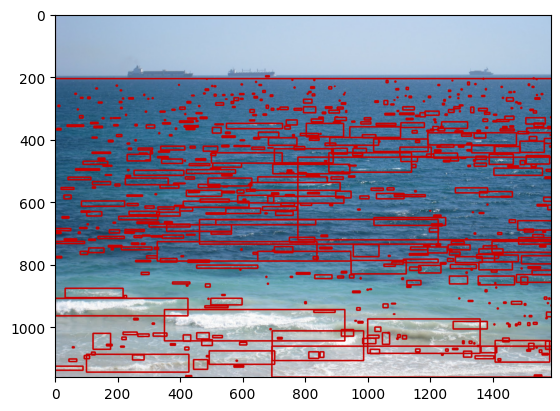

In [127]:
frame_out = cropped_image.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    frame_out = cv2.rectangle(frame_out, (x, y), (x+w, y+h), (0, 0, 200), 3)

cv2_imshow(frame_out)